In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import math
from scipy.signal import savgol_filter

from CCDPApy.helper import output_path, input_path

#sns.set_theme(style="darkgrid")
sns.set_theme(style="whitegrid", palette="pastel")

pd.set_option('display.max_columns', 200)

In [2]:
# loading data
path = output_path('genetech_raw_2.csv')
df = pd.read_csv(path)

# fill NAN with np.nan
df = df.fillna(np.nan)

df.head(3)

Date (MM/DD/YY H:MM:SS AM/PM) Cell Line      ID      Name  \
0           2023-01-01 00:00:00      CL G  295008  Genetech   
1           2023-01-01 10:00:00      CL G  295008  Genetech   
2           2023-01-01 20:00:00      CL G  295008  Genetech   

   Initial Volume (mL)  Sample Volume (mL)  Volume Before Sampling (mL)  \
0             12000000                   0                     12000000   
1             12000000                   0                     12000000   
2             12000000                   0                     12000000   

   Volume After Sampling (mL)  Feed Media Added (mL)  Feed Status  # Feed  \
0                    12000000                      0            0       2   
1                    12000000                      0            0       2   
2                    12000000                      0            0       2   

   base        osmo       vcd       dcd       tcd  IgG (mg/L)      NH4+  \
0   0.0  310.390602  0.707812  0.006987  0.714800           0  3.071507   
1   0.0  294.969383  1.685265  0.051820  1.737085           0  3.621828   
2   0.0  297.612555  1.544325  0.047093  1.591418           0  4.172149   

         Na+     Titer   IntvPCV       PCV       pCO2     pHoff         pO2  \
0  46.345103  1.059949  0.000000  0.167421  93.000259  6.960743  101.258254   
1  45.663156  1.059949  0.347610  0.258416  81.143342  7.002544   99.957496   
2  44.981209  1.059949  1.803381  0.364611  69.286425  7.014704   98.656738   

   air sparge  air sparge sp  air sparge total  backpressure  co2 sparge  \
0   11.408122       5.688135       12734.85202      1.978115    3.245566   
1   53.190310      26.830021       26831.18445      1.981209    3.325126   
2   71.584015      35.751700       64305.34848      1.972489    3.253458   

   co2 sparge total  do2 controller output  do2 primary  do2 secondary  \
0       2785.682712               1.547035    29.921898      29.161844   
1       1858.298578               7.096126    28.151353      28.057887   
2       3794.494966               9.549251    30.234508      30.208355   

   flowrate overlay  oxygen sparge  oxygen sparge total  ph controller output  \
0        250.984953            0.0                  0.0             46.003623   
1        251.001728            0.0                  0.0             45.862719   
2        250.950363            0.0                  0.0             45.911384   

   ph primary  pressure exhaust valve  sparge total  temperature  \
0    7.028866               70.414004     11.278256    36.949926   
1    7.030608               70.302097     53.020003    37.042912   
2    7.028387               71.111027     71.403806    36.996902   

   temperature jacket  weight load cell Titer_range Titer_group       viab  \
0           37.437632        9452.84421   1.05-1.10  Middle 60%  99.022465   
1           37.259285       10349.50443   1.05-1.10  Middle 60%  97.016840   
2           37.371550       10343.89697   1.05-1.10  Middle 60%  97.040803   

   Titer_category  Run Time (day)  Run Time (hr)        glc        lac  \
0               0               0            0.0  62.829937   5.794531   
1               0               0           10.0  62.126848   9.078070   
2               0               0           20.0  59.375606  13.064794   

   glc_after  lac_after         ccell       ivcc  IgG (mg)          cglc  \
0  62.829937   5.794531  0.000000e+00   0.000000         0      0.000000   
1  62.126848   9.078070  1.172944e+07  11.965388         0   8437.068541   
2  59.375606  13.064794  1.003815e+07  28.113340         0  41451.971625   

           clac        mu  IgG (mg/10^9 cells/hr)      qglc      qlac  \
0      0.000000       NaN                     NaN       NaN       NaN   
1  39402.468250  0.081690                     0.0  0.058760  0.274420   
2  87243.157993 -0.008728                     0.0  0.170377  0.246887   

    mu_poly  qIgG_poly (mg/10^9 cells/hr)  qglc_poly  qlac_poly  
0       NaN                             0   0.1

In [3]:
def make_plot_df(data):
    '''create dataframe for plotting'''
    columns_drop = [
        'Date (MM/DD/YY H:MM:SS AM/PM)', 
        'Cell Line', 
        'Name',
        'Initial Volume (mL)', 
        'Sample Volume (mL)', 
        'Volume Before Sampling (mL)', 
        'Volume After Sampling (mL)',
        'Feed Media Added (mL)', 
        'Feed Status', 
        '# Feed', 
        'IgG (mg/L)', 
        'IgG (mg)', 
        'IgG (mg/10^9 cells/hr)',
        'qIgG_poly (mg/10^9 cells/hr)'
    ]
    df = data.drop(columns=columns_drop, axis=1)
    id_cols = [
        'ID', 'Titer', 'Titer_range', 'Titer_group', 'Titer_category',
        'Run Time (day)', 'Run Time (hr)', 'glc_after', 'lac_after',
    ]
    plot_df = df.melt(id_vars=id_cols, var_name='Parameter', value_name="Value")
    return plot_df

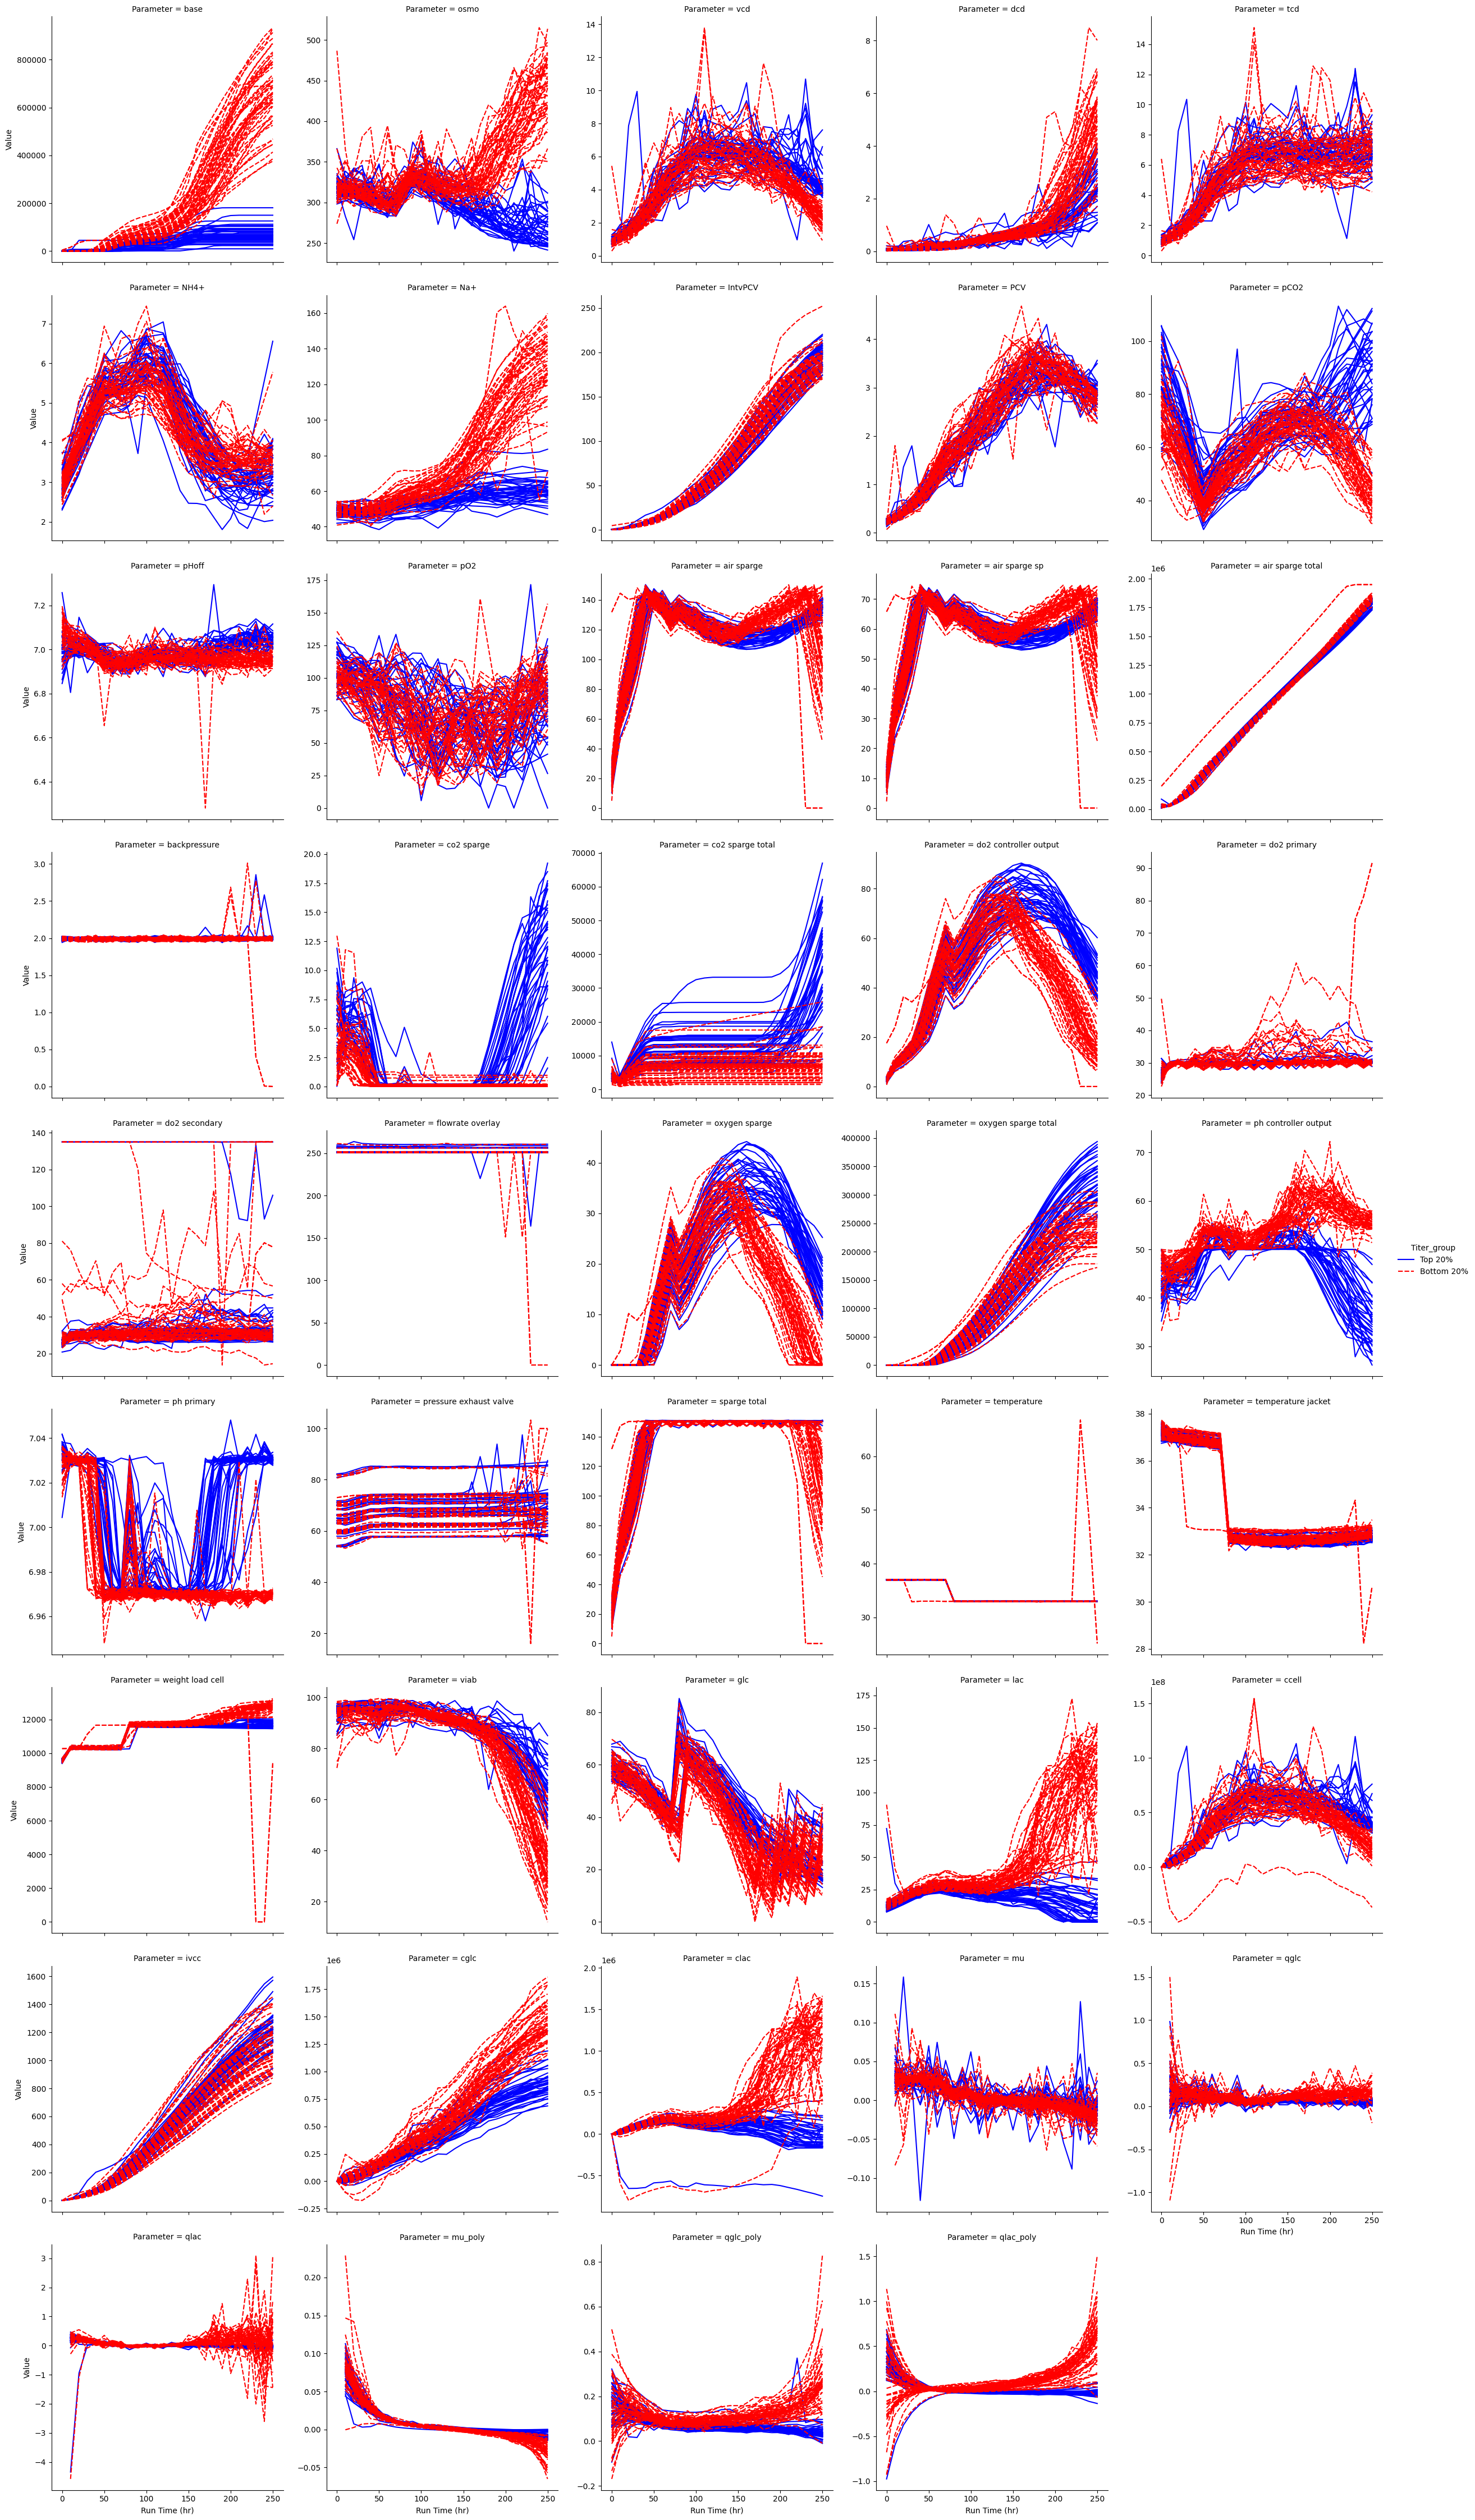

In [4]:
# Plotting Profiles
plot_df = make_plot_df(data=df)
colors = ["b", "r"]
sns.set_palette(colors)
x = 'Run Time (hr)'
y = 'Value'
sns.relplot(data=plot_df[plot_df['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            col_wrap=5,
            facet_kws={'sharey': False, 'sharex': True},)
plt.show()

# Smoothing

In [4]:
df.head(3)

Date (MM/DD/YY H:MM:SS AM/PM) Cell Line      ID      Name  \
0           2023-01-01 00:00:00      CL G  295008  Genetech   
1           2023-01-01 10:00:00      CL G  295008  Genetech   
2           2023-01-01 20:00:00      CL G  295008  Genetech   

   Initial Volume (mL)  Sample Volume (mL)  Volume Before Sampling (mL)  \
0             12000000                   0                     12000000   
1             12000000                   0                     12000000   
2             12000000                   0                     12000000   

   Volume After Sampling (mL)  Feed Media Added (mL)  Feed Status  # Feed  \
0                    12000000                      0            0       2   
1                    12000000                      0            0       2   
2                    12000000                      0            0       2   

   base        osmo       vcd       dcd       tcd  IgG (mg/L)      NH4+  \
0   0.0  310.390602  0.707812  0.006987  0.714800           0  3.071507   
1   0.0  294.969383  1.685265  0.051820  1.737085           0  3.621828   
2   0.0  297.612555  1.544325  0.047093  1.591418           0  4.172149   

         Na+     Titer   IntvPCV       PCV       pCO2     pHoff         pO2  \
0  46.345103  1.059949  0.000000  0.167421  93.000259  6.960743  101.258254   
1  45.663156  1.059949  0.347610  0.258416  81.143342  7.002544   99.957496   
2  44.981209  1.059949  1.803381  0.364611  69.286425  7.014704   98.656738   

   air sparge  air sparge sp  air sparge total  backpressure  co2 sparge  \
0   11.408122       5.688135       12734.85202      1.978115    3.245566   
1   53.190310      26.830021       26831.18445      1.981209    3.325126   
2   71.584015      35.751700       64305.34848      1.972489    3.253458   

   co2 sparge total  do2 controller output  do2 primary  do2 secondary  \
0       2785.682712               1.547035    29.921898      29.161844   
1       1858.298578               7.096126    28.151353      28.057887   
2       3794.494966               9.549251    30.234508      30.208355   

   flowrate overlay  oxygen sparge  oxygen sparge total  ph controller output  \
0        250.984953            0.0                  0.0             46.003623   
1        251.001728            0.0                  0.0             45.862719   
2        250.950363            0.0                  0.0             45.911384   

   ph primary  pressure exhaust valve  sparge total  temperature  \
0    7.028866               70.414004     11.278256    36.949926   
1    7.030608               70.302097     53.020003    37.042912   
2    7.028387               71.111027     71.403806    36.996902   

   temperature jacket  weight load cell Titer_range Titer_group       viab  \
0           37.437632        9452.84421   1.05-1.10  Middle 60%  99.022465   
1           37.259285       10349.50443   1.05-1.10  Middle 60%  97.016840   
2           37.371550       10343.89697   1.05-1.10  Middle 60%  97.040803   

   Titer_category  Run Time (day)  Run Time (hr)        glc        lac  \
0               0               0            0.0  62.829937   5.794531   
1               0               0           10.0  62.126848   9.078070   
2               0               0           20.0  59.375606  13.064794   

   glc_after  lac_after         ccell       ivcc  IgG (mg)          cglc  \
0  62.829937   5.794531  0.000000e+00   0.000000         0      0.000000   
1  62.126848   9.078070  1.172944e+07  11.965388         0   8437.068541   
2  59.375606  13.064794  1.003815e+07  28.113340         0  41451.971625   

           clac        mu  IgG (mg/10^9 cells/hr)      qglc      qlac  \
0      0.000000       NaN                     NaN       NaN       NaN   
1  39402.468250  0.081690                     0.0  0.058760  0.274420   
2  87243.157993 -0.008728                     0.0  0.170377  0.246887   

    mu_poly  qIgG_poly (mg/10^9 cells/hr)  qglc_poly  qlac_poly  
0       NaN                             0   0.1

In [5]:
# extrapolate mu
params_smooth = {'mu': 4}

x = df['Run Time (hr)'].unique()
x = x.astype(float)
df_list = []

'''for _, group_df in df.groupby(by='ID'):
    temp_list = []
    for param, deg in params_smooth.items():
        y = group_df[param].to_numpy().astype(float)
        coefficients = np.polyfit(x[1:], y[1:], deg=deg)
        poly_function = np.poly1d(coefficients)
        y[0] = poly_function[0]
        group_df[param] = y
        
        temp_list.append(group_df)
    temp = pd.concat(temp_list, axis=1)
    df_list.append(temp)

df = pd.concat(df_list, axis=0).reset_index(drop=True)
df.head()'''

Date (MM/DD/YY H:MM:SS AM/PM) Cell Line      ID      Name  \
0           2023-01-01 00:00:00      CL G  295008  Genetech   
1           2023-01-01 10:00:00      CL G  295008  Genetech   
2           2023-01-01 20:00:00      CL G  295008  Genetech   
3           2023-01-02 06:00:00      CL G  295008  Genetech   
4           2023-01-02 16:00:00      CL G  295008  Genetech   

   Initial Volume (mL)  Sample Volume (mL)  Volume Before Sampling (mL)  \
0             12000000                   0                     12000000   
1             12000000                   0                     12000000   
2             12000000                   0                     12000000   
3             12000000                   0                     12000000   
4             12000000                   0                     12000000   

   Volume After Sampling (mL)  Feed Media Added (mL)  Feed Status  # Feed  \
0                    12000000                      0            0       2   
1                    12000000                      0            0       2   
2                    12000000                      0            0       2   
3                    12000000                      0            0       2   
4                    12000000                      0            0       2   

   base        osmo       vcd       dcd       tcd  IgG (mg/L)      NH4+  \
0   0.0  310.390602  0.707812  0.006987  0.714800           0  3.071507   
1   0.0  294.969383  1.685265  0.051820  1.737085           0  3.621828   
2   0.0  297.612555  1.544325  0.047093  1.591418           0  4.172149   
3   0.0  297.060884  1.858663  0.056206  1.914869           0  4.532507   
4   0.0  293.574929  2.494772  0.104573  2.599345           0  4.699150   

         Na+     Titer   IntvPCV       PCV       pCO2     pHoff         pO2  \
0  46.345103  1.059949  0.000000  0.167421  93.000259  6.960743  101.258254   
1  45.663156  1.059949  0.347610  0.258416  81.143342  7.002544   99.957496   
2  44.981209  1.059949  1.803381  0.364611  69.286425  7.014704   98.656738   
3  44.299261  1.059949  3.521618  0.482487  59.669689  7.004803   94.844104   
4  40.892881  1.059949  5.738774  0.634560  52.337375  6.976747   88.469988   

   air sparge  air sparge sp  air sparge total  backpressure  co2 sparge  \
0   11.408122       5.688135       12734.85202      1.978115    3.245566   
1   53.190310      26.830021       26831.18445      1.981209    3.325126   
2   71.584015      35.751700       64305.34848      1.972489    3.253458   
3   93.778188      46.761039      113614.71560      1.964130    3.507787   
4  125.706899      62.624315      178875.49560      1.965074    3.354045   

   co2 sparge total  do2 controller output  do2 primary  do2 secondary  \
0       2785.682712               1.547035    29.921898      29.161844   
1       1858.298578               7.096126    28.151353      28.057887   
2       3794.494966               9.549251    30.234508      30.208355   
3       5868.770835              12.521825    28.366251      29.168578   
4       7993.900298              16.706876    29.904632      30.813889   

   flowrate overlay  oxygen sparge  oxygen sparge total  ph controller output  \
0        250.984953            0.0                  0.0             46.003623   
1        251.001728            0.0                  0.0             45.862719   
2        250.950363            0.0                  0.0             45.911384   
3        250.965823            0.0                  0.0             45.679751   
4        250.743895            0.0                  0.0             45.847410   

   ph primary  pressure exhaust valve  sparge total  temperature  \
0    7.028866               70.414004     11.278256    36.949926   
1    7.030608               70.302097     53.020003    37.042912   
2    7.028387               71.111027     71.403806    36.996902   
3    7.031762               71.877170     93.974310    36.996902   
4    7.029856               72.944823    125.554414   

In [6]:
df['mu'].isna().any()

False

In [5]:
def smooth_by_poly(x, y, deg=3):
    # Fit the polynomial to the data
    if math.isnan(y[0]):
        coefficients = np.polyfit(x[1:], y[1:], deg=deg)
    else:
        coefficients = np.polyfit(x, y, deg=deg)
    # Create a polynomial function from the coefficients
    poly_function = np.poly1d(coefficients)
    # Generate smoothed y values using the polynomial function
    return poly_function(x)

def smooth_by_svgol(x, window_size=7, poly_order=3):
    # 
    x_smoothed = savgol_filter(x, window_length=window_size, polyorder=poly_order, mode="nearest")
    return x_smoothed

In [8]:
# Parameters to smooth
params_smooth = {'osmo': 4, 'vcd':4, 'lac':4, 'mu': 4}

x = df['Run Time (hr)'].unique()
df_list = []

for _, group_df in df.groupby(by='ID'):
    temp_list = []
    for param, degree in params_smooth.items():
        y_row = group_df[param].to_numpy()
        y_smooth = smooth_by_svgol(y_row, window_size=20, poly_order=degree)

        if param=='mu':
            y_smooth = smooth_by_poly(x, y_row, deg=degree)
        
        temp_list.append(pd.DataFrame(data={f'{param}_s': y_smooth}))
    temp = pd.concat(temp_list, axis=1)
    df_list.append(temp)

df_smoothed = pd.concat(df_list, axis=0).reset_index(drop=True)
df_smoothed.head()

osmo_s     vcd_s      lac_s      mu_s
0  301.028587  1.119630   9.053800  0.060916
1  297.662207  1.496163  11.415765  0.046863
2  295.581111  1.662210  14.103841  0.035802
3  295.169148  1.938018  16.836007  0.027269
4  296.903417  2.439821  19.602439  0.020835

In [9]:
# check negative values in vcd and lac
df_smoothed.describe()

osmo_s        vcd_s        lac_s         mu_s
count  6318.000000  6318.000000  6318.000000  6318.000000
mean    314.846699     4.623629    30.547961     0.006379
std      34.237344     1.761954    23.034756     0.015051
min     240.159128     0.552384    -1.332659    -0.130657
25%     298.840050     3.508369    20.021551    -0.003345
50%     312.172955     4.832294    24.751582     0.001444
75%     323.119738     5.940947    30.085924     0.017883
max     496.356793     9.639876   151.866388     0.187089

In [10]:
# Replace negative values with zeros
cols = ['lac_s']
df_smoothed[cols] = df_smoothed[cols].clip(lower=0)

df_smoothed.describe()

osmo_s        vcd_s        lac_s         mu_s
count  6318.000000  6318.000000  6318.000000  6318.000000
mean    314.846699     4.623629    30.550939     0.006379
std      34.237344     1.761954    23.030763     0.015051
min     240.159128     0.552384     0.000000    -0.130657
25%     298.840050     3.508369    20.021551    -0.003345
50%     312.172955     4.832294    24.751582     0.001444
75%     323.119738     5.940947    30.085924     0.017883
max     496.356793     9.639876   151.866388     0.187089

In [11]:
# Combine
df_smoothed = pd.concat([df, df_smoothed], axis=1)
df_smoothed.head()

Date (MM/DD/YY H:MM:SS AM/PM) Cell Line      ID      Name  \
0           2023-01-01 00:00:00      CL G  295008  Genetech   
1           2023-01-01 10:00:00      CL G  295008  Genetech   
2           2023-01-01 20:00:00      CL G  295008  Genetech   
3           2023-01-02 06:00:00      CL G  295008  Genetech   
4           2023-01-02 16:00:00      CL G  295008  Genetech   

   Initial Volume (mL)  Sample Volume (mL)  Volume Before Sampling (mL)  \
0             12000000                   0                     12000000   
1             12000000                   0                     12000000   
2             12000000                   0                     12000000   
3             12000000                   0                     12000000   
4             12000000                   0                     12000000   

   Volume After Sampling (mL)  Feed Media Added (mL)  Feed Status  # Feed  \
0                    12000000                      0            0       2   
1                    12000000                      0            0       2   
2                    12000000                      0            0       2   
3                    12000000                      0            0       2   
4                    12000000                      0            0       2   

   base        osmo       vcd       dcd       tcd  IgG (mg/L)      NH4+  \
0   0.0  310.390602  0.707812  0.006987  0.714800           0  3.071507   
1   0.0  294.969383  1.685265  0.051820  1.737085           0  3.621828   
2   0.0  297.612555  1.544325  0.047093  1.591418           0  4.172149   
3   0.0  297.060884  1.858663  0.056206  1.914869           0  4.532507   
4   0.0  293.574929  2.494772  0.104573  2.599345           0  4.699150   

         Na+     Titer   IntvPCV       PCV       pCO2     pHoff         pO2  \
0  46.345103  1.059949  0.000000  0.167421  93.000259  6.960743  101.258254   
1  45.663156  1.059949  0.347610  0.258416  81.143342  7.002544   99.957496   
2  44.981209  1.059949  1.803381  0.364611  69.286425  7.014704   98.656738   
3  44.299261  1.059949  3.521618  0.482487  59.669689  7.004803   94.844104   
4  40.892881  1.059949  5.738774  0.634560  52.337375  6.976747   88.469988   

   air sparge  air sparge sp  air sparge total  backpressure  co2 sparge  \
0   11.408122       5.688135       12734.85202      1.978115    3.245566   
1   53.190310      26.830021       26831.18445      1.981209    3.325126   
2   71.584015      35.751700       64305.34848      1.972489    3.253458   
3   93.778188      46.761039      113614.71560      1.964130    3.507787   
4  125.706899      62.624315      178875.49560      1.965074    3.354045   

   co2 sparge total  do2 controller output  do2 primary  do2 secondary  \
0       2785.682712               1.547035    29.921898      29.161844   
1       1858.298578               7.096126    28.151353      28.057887   
2       3794.494966               9.549251    30.234508      30.208355   
3       5868.770835              12.521825    28.366251      29.168578   
4       7993.900298              16.706876    29.904632      30.813889   

   flowrate overlay  oxygen sparge  oxygen sparge total  ph controller output  \
0        250.984953            0.0                  0.0             46.003623   
1        251.001728            0.0                  0.0             45.862719   
2        250.950363            0.0                  0.0             45.911384   
3        250.965823            0.0                  0.0             45.679751   
4        250.743895            0.0                  0.0             45.847410   

   ph primary  pressure exhaust valve  sparge total  temperature  \
0    7.028866               70.414004     11.278256    36.949926   
1    7.030608               70.302097     53.020003    37.042912   
2    7.028387               71.111027     71.403806    36.996902   
3    7.031762               71.877170     93.974310    36.996902   
4    7.029856               72.944823    125.554414   

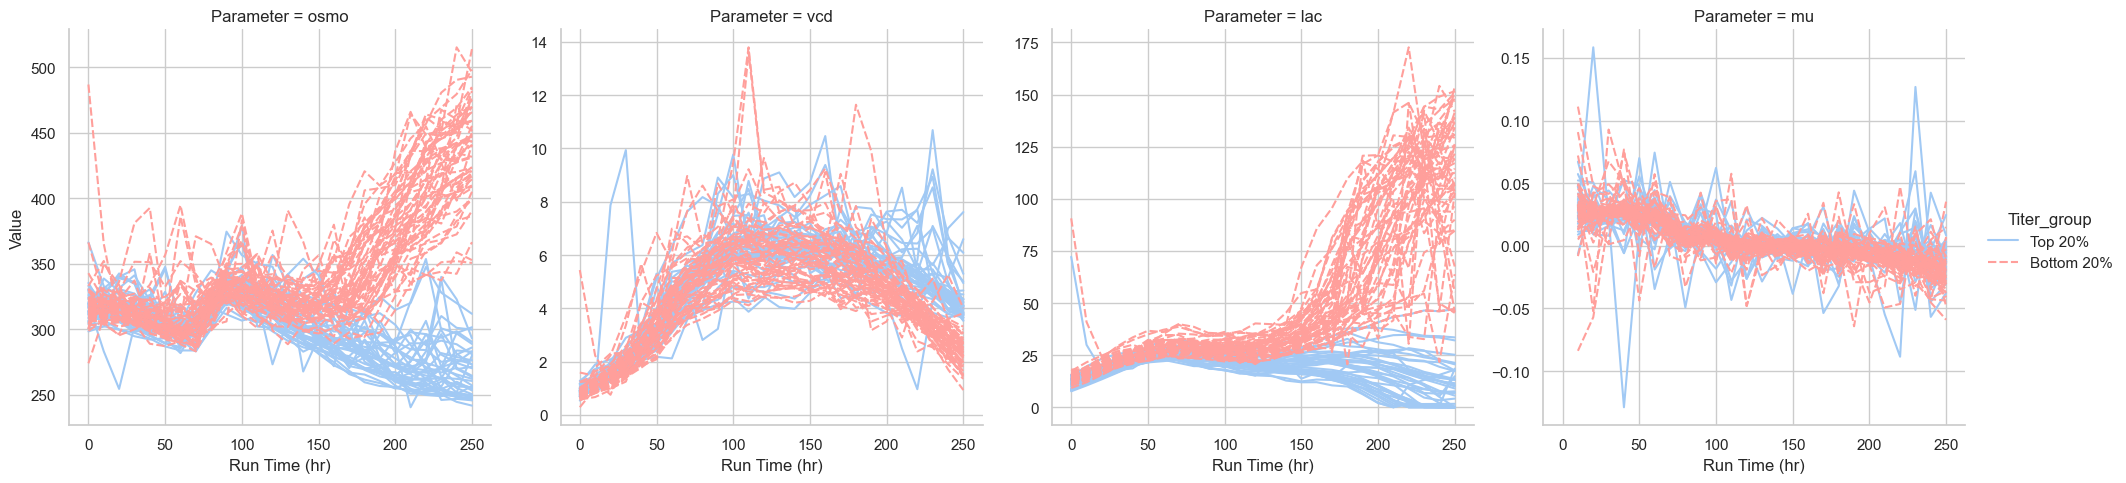

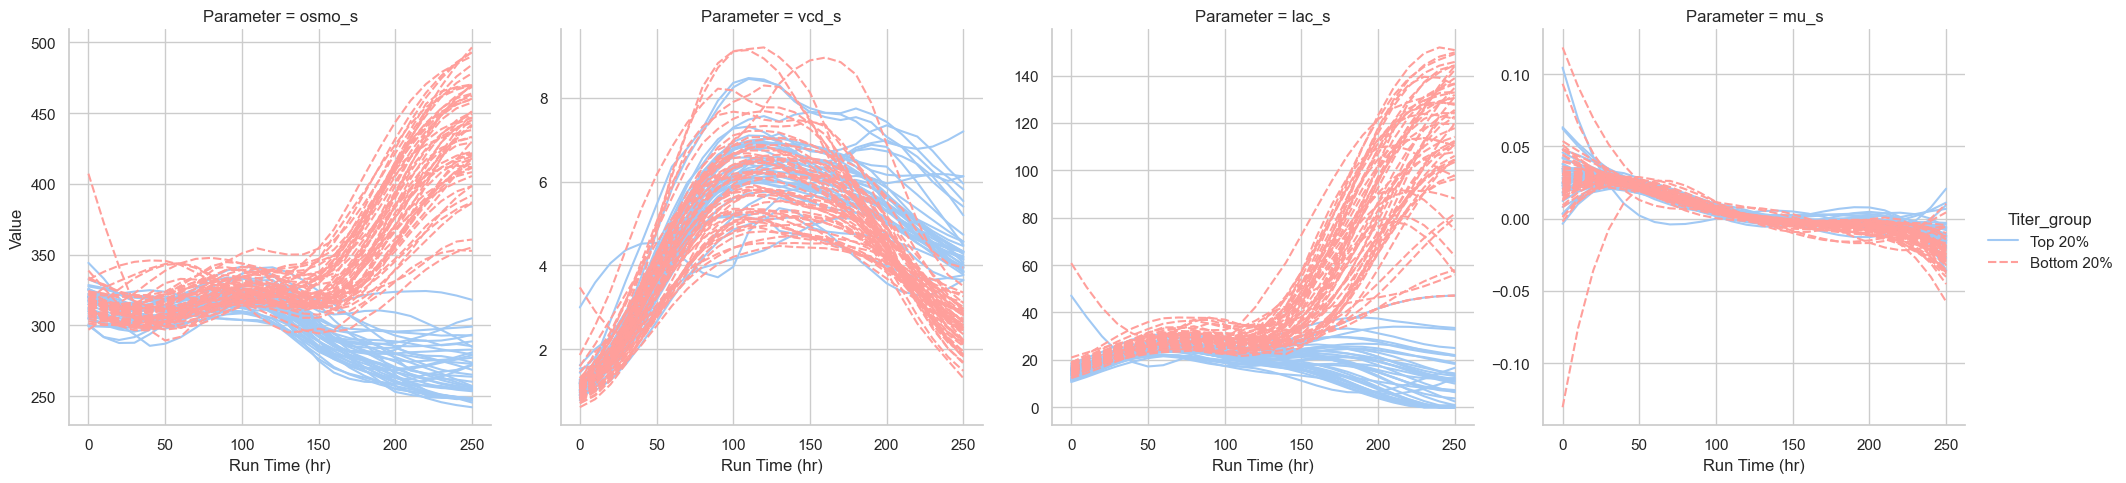

In [12]:
# Plotting Profiles
plot_df = make_plot_df(data=df_smoothed)
plot_mask = (plot_df['Parameter']=='osmo')|(plot_df['Parameter']=='vcd')|(plot_df['Parameter']=='lac')|(plot_df['Parameter']=='mu')
plot_df_raw = plot_df[plot_mask]

plot_mask = (plot_df['Parameter']=='osmo_s')|(plot_df['Parameter']=='vcd_s')|(plot_df['Parameter']=='lac_s')|(plot_df['Parameter']=='mu_s')
plot_df_smoothed = plot_df[plot_mask]

colors = ["b", "r"]
sns.set_palette(colors)

x = 'Run Time (hr)'
y = 'Value'

sns.relplot(data=plot_df_raw[plot_df_raw['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            # col_wrap=5,
            facet_kws={'sharey': False, 'sharex': True},)

sns.relplot(data=plot_df_smoothed[plot_df_smoothed['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            # col_wrap=5,
            facet_kws={'sharey': False, 'sharex': True},)

plt.show()

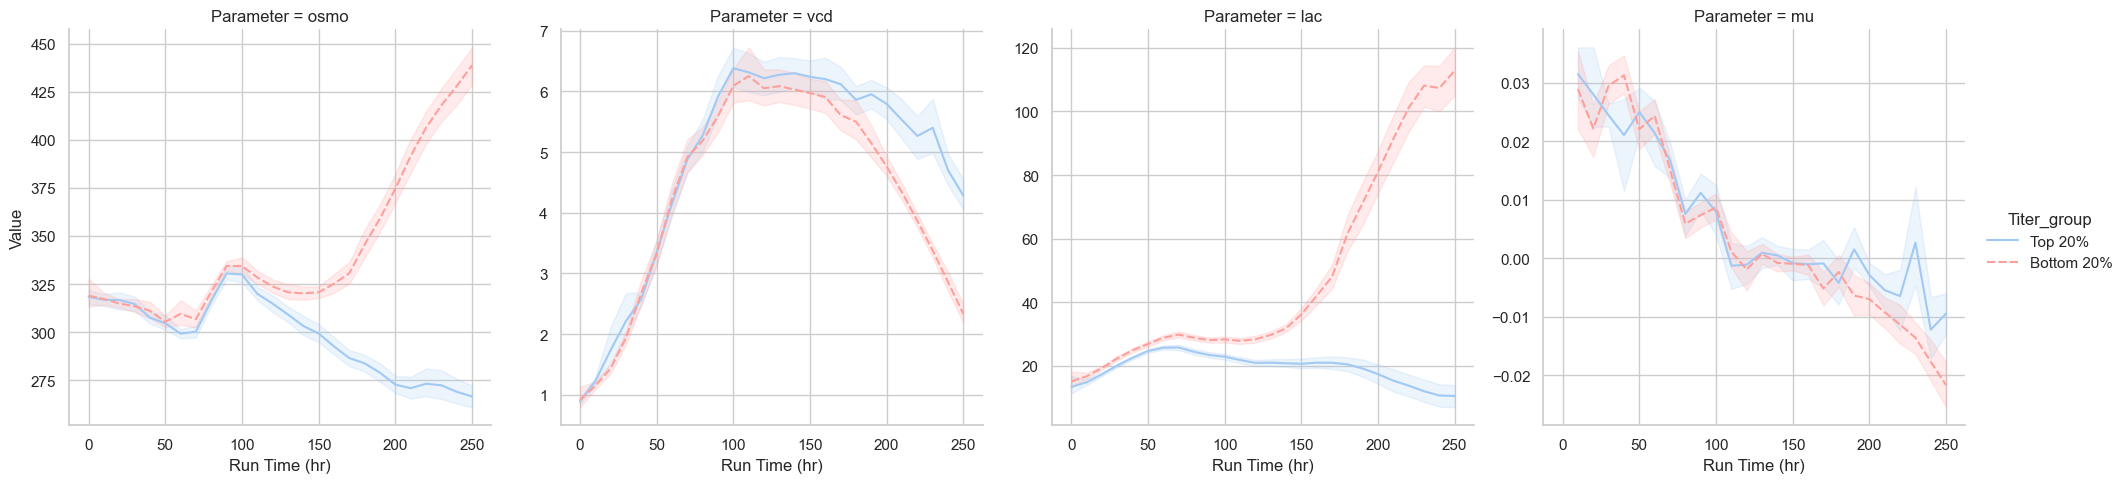

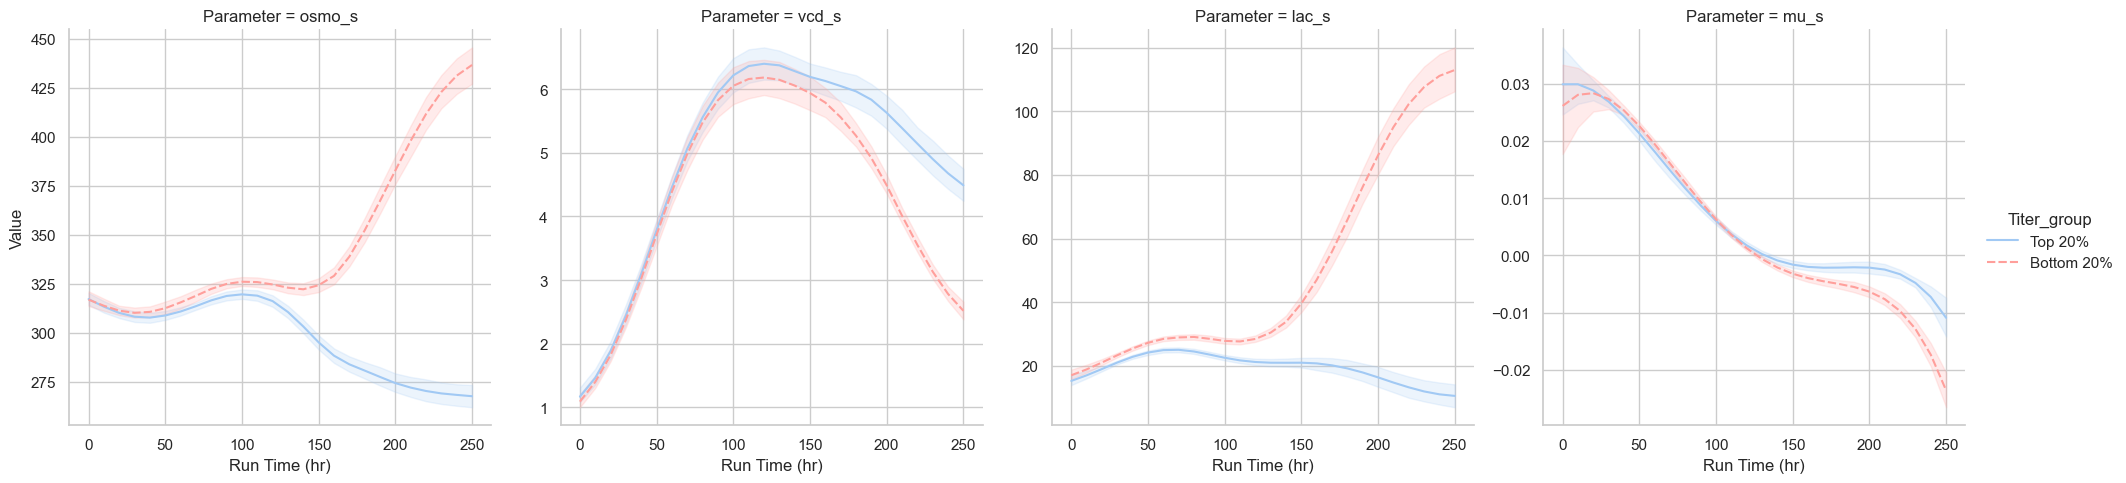

In [13]:
sns.relplot(data=plot_df_raw[plot_df_raw['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            facet_kws={'sharey': False, 'sharex': True},)

sns.relplot(data=plot_df_smoothed[plot_df_smoothed['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            # col_wrap=5,
            facet_kws={'sharey': False, 'sharex': True},)

plt.show()

In [14]:
# Saving
path = output_path('genetech_raw_smoothed.csv')
df_smoothed.to_csv(path, index=False)

# PLSR Parameters

In [ ]:
df.head(3)

In [ ]:
'''
PLSR = ['pH contrlleer output', 'DO (primary)', 'total base added', 'Backpressure', 'Na+', 
        'pH (online)', 'Jacket temperature', 'pO2', 'pCO2', 'viability']

VSR = ['total base added', 'HH4+', 'viability', 'pO2', 'Flowrate overlay', 
       'pH (offline)', 'DO (primary)', 'IntvPCV', 'Reactor weight', 'Air sparge output']
'''

In [ ]:
PLSR_params_1 = ['ph controller output', 'do2 primary', 'base', 'backpressure', 'Na+']
PLSR_params_2 = ['ph primary', 'temperature jacket', 'pO2', 'pCO2', 'viab']

SVR_params_1 = ['base', 'NH4+', 'viab', 'pO2', 'flowrate overlay']
SVR_params_2 = ['pHoff', 'do2 primary', 'IntvPCV', 'weight load cell', 'air sparge']

In [ ]:
PLSR_mask = (plot_df['Parameter']==PLSR_params_1[0])|(plot_df['Parameter']==PLSR_params_1[1])|(plot_df['Parameter']==PLSR_params_1[2])|(plot_df['Parameter']==PLSR_params_1[3])|(plot_df['Parameter']==PLSR_params_1[4])
PLSR_plot_df = plot_df[PLSR_mask]

colors = ["b", "r"]
sns.set_palette(colors)
x = 'Run Time (hr)'
y = 'Value'
sns.relplot(data=PLSR_plot_df[PLSR_plot_df['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            #col_wrap=3,
            col_order=PLSR_params_1,
            facet_kws={'sharey': False, 'sharex': True},)
plt.show()

In [ ]:
PLSR_mask = (plot_df['Parameter']==PLSR_params_2[0])|(plot_df['Parameter']==PLSR_params_2[1])|(plot_df['Parameter']==PLSR_params_2[2])|(plot_df['Parameter']==PLSR_params_2[3])|(plot_df['Parameter']==PLSR_params_2[4])
PLSR_plot_df = plot_df[PLSR_mask]

colors = ["b", "r"]
sns.set_palette(colors)
x = 'Run Time (hr)'
y = 'Value'
sns.relplot(data=PLSR_plot_df[PLSR_plot_df['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            #col_wrap=3,
            col_order=PLSR_params_2,
            facet_kws={'sharey': False, 'sharex': True},)
plt.show()

In [ ]:
SVR_mask = (plot_df['Parameter']==SVR_params_1[0])|(plot_df['Parameter']==SVR_params_1[1])|(plot_df['Parameter']==SVR_params_1[2])|(plot_df['Parameter']==SVR_params_1[3])|(plot_df['Parameter']==SVR_params_1[4])
SVR_plot_df = plot_df[SVR_mask]

colors = ["b", "r"]
sns.set_palette(colors)
x = 'Run Time (hr)'
y = 'Value'
sns.relplot(data=SVR_plot_df[SVR_plot_df['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            # col_wrap=3,
            col_order=SVR_params_1,
            facet_kws={'sharey': False, 'sharex': True},)
plt.show()

In [ ]:
SVR_mask = (plot_df['Parameter']==SVR_params_2[0])|(plot_df['Parameter']==SVR_params_2[1])|(plot_df['Parameter']==SVR_params_2[2])|(plot_df['Parameter']==SVR_params_2[3])|(plot_df['Parameter']==SVR_params_2[4])
SVR_plot_df = plot_df[SVR_mask]

colors = ["b", "r"]
sns.set_palette(colors)
x = 'Run Time (hr)'
y = 'Value'
sns.relplot(data=SVR_plot_df[SVR_plot_df['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            # col_wrap=3,
            col_order=SVR_params_2,
            facet_kws={'sharey': False, 'sharex': True},)
plt.show()

In [ ]:
# Other params
other_params = ['weight load cell', 'pCO2', 'co2 sparge', 'co2 sparge total', 'oxygen sparge', 'oxygen sparge total']

mask = (plot_df['Parameter']==other_params[0])|(plot_df['Parameter']==other_params[1])|(plot_df['Parameter']==other_params[2])|(plot_df['Parameter']==other_params[3])|(plot_df['Parameter']==other_params[4])|(plot_df['Parameter']==other_params[5])
plot_df2 = plot_df[mask]

colors = ["b", "r"]
sns.set_palette(colors)
x = 'Run Time (hr)'
y = 'Value'
sns.relplot(data=plot_df2[plot_df2['Titer_group']!='Middle 60%'], x=x, y=y, kind='line',
            estimator=None, units='ID',
            hue='Titer_group', hue_order=['Top 20%', 'Bottom 20%'],
            style='Titer_group', style_order=['Top 20%', 'Bottom 20%'],
            col='Parameter',
            col_wrap=3,
            col_order=SVR_params_2,
            facet_kws={'sharey': False, 'sharex': True},)
plt.show()

In [ ]:
plot_df2['Parameter'].unique()
